### Generate JCM Default Statistics

This notebook is used to generate the statistics (zonal mean and std deviation) used in the model unit test model_test.py:test_speedy_model_default_statistics(). If the model behavior changes meaningfully we will want to rerun these and generate a new default_statistics.nc file.

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu" # for use on ARM Macs

import jax
print("JAX device:", jax.devices())
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

JAX device: [CpuDevice(id=0)]


W0000 00:00:1763667496.088453 26339474 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1763667496.098142 26339474 service.cc:145] XLA service 0x14a026db0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763667496.098157 26339474 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1763667496.099180 26339474 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1763667496.099187 26339474 mps_client.cc:384] XLA backend will use up to 28990554112 bytes on device 0 for SimpleAllocator.


In [2]:
from jcm.data.test.t30.generate_default_stats import run_default_speedy_model
model, predictions = run_default_speedy_model()

forcing_t31.nc already exists.
terrain_t31.nc already exists.


In [ ]:
pred_ds = predictions.to_xarray()

In [4]:
pred_ds_mean = pred_ds.resample(time='1ME').mean().isel(time=-1).mean(dim={'lon', 'lat'}) # resample to monthly intervals
pred_ds_std = pred_ds.mean(dim={'lon', 'lat'}).std(dim='time') # resample to monthly intervals, TODO: weight global averages

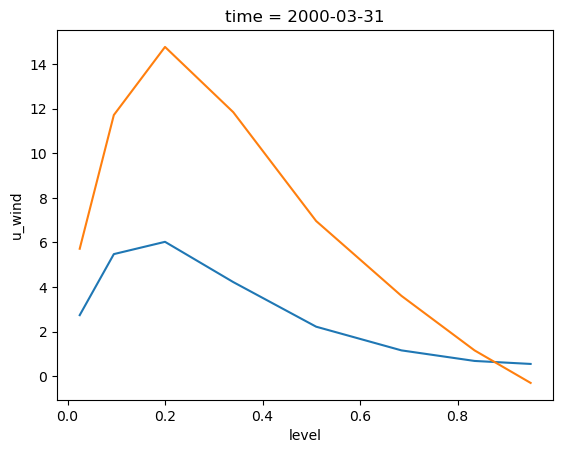

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pred_ds_std.u_wind.plot(ax=ax)
pred_ds_mean.u_wind.plot(ax=ax)

#### Save Stats to netCDF

In [9]:
from jcm.data.test.t30.generate_default_stats import default_stat_vars

#create empty dictionary
ds_dict = {}

for var in default_stat_vars:
    # add a new xarray dataset to the dictionary for each variable
    ds_dict[f'{var}.mean'] = pred_ds_mean[var]
    ds_dict[f'{var}.std'] = pred_ds_std[var]

In [10]:
import xarray as xr
ds = xr.Dataset(ds_dict)

In [ ]:
ds.to_netcdf('jcm/data/test/t30/default_statistics.nc')